In [4]:

import yaml
import os

from numpy import *
import luxeics
import h5py

from scipy.interpolate import interp2d,RectBivariateSpline

import matplotlib.pyplot as plt

import luxeics


def Photon_density(xoffset,yoffset,X1,X2,baseline,spotsize,sigmaT,W,path):
    
    
    Area=pi*spotsize**2

    
    selector= sqrt((xoffset+X1)**2+(yoffset+X2)**2) < spotsize



    P=sum(W[selector ] )/Area
    
#     print ( f'Photon density, finite source size:',P)
    
#     print (' ######################################### '  )
#     print ('                           '  )
#     plt.figure(figsize=(14,6))

    

#     ax1=plt.subplot(122,aspect=1)

#     # plot(X1+xoffset, X2+yoffset, color='m', marker=',',lw=0);





#     plt.scatter(X1+xoffset, X2+yoffset, color='m', marker='.',lw=0,s=W);

#     plt.xlim(-2*spotsize,2*spotsize)
#     plt.ylim(-2*spotsize,2*spotsize)
    
#     plt.xlabel(r'$x$ (micron)')
#     plt.ylabel(r'$y$ (micron)');
#     plt.title(f'Finite source size, Photon density:{round(P,2)} micron^(-2)')

    
#     ax1.add_patch(plt.Circle((0,0),spotsize,color='C0',fill=False))


#     plt.suptitle(f' sigmaT :{sigmaT} micron ; spotsize:{spotsize} micron')
#     plt.savefig(f'{path}\photon_spectrum_at_focus_{sigmaT}_{spotsize}.png',dpi=200)
    
    return(P)
                                      
    
                                   
def run(spotsize,input_filename,path):
    

    
    
    with h5py.File(input_filename + '.h5' ,'r') as ff:
    #     omega      = ff['final-state/spectrum/omega'][:]/1e9
    #     theta      = ff['final-state/spectrum/theta'][:]*1e6
    #     spectrum   = ff['final-state/spectrum/spectrum'][:]

        K0,K1,K2,K3  = ff['final-state/photon/momentum'][:].T
        X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
        W            = ff['final-state/photon/weight'  ][:]

        P0,P1,P2,P3  = ff['final-state/electron/momentum'][:].T
    #     X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
    #     We            = ff['final-state/photon/weight'  ][:]
    with open( input_filename + '.yml', 'r' ) as stream:
        input_dict = yaml.load(stream, Loader=yaml.SafeLoader)

        mode             = input_dict['control']['mode']


        beam_charge      = float( input_dict['beam']['beam_charge'])
        number_electrons = int( beam_charge / 1.60217653e-19)

    #     sampling         = input_dict['control']['sampling']
        sampling = mode

        w0               = float(input_dict['laser']['w0'])
        omega0           = float(input_dict['laser']['omega0'])
        gamma            = float(input_dict['beam']['gamma'])
        Xr               = 4*gamma*omega0/511*10**(-3)
        energyspread     = float(input_dict['beam']['energyspread'])
        sigmaT   = float(input_dict['beam']['sigmaT'])

    baseline = 7.5e6

    thetax=K1/K3
    thetay=K2/K3

     

    xoffset = thetax * baseline
    yoffset = thetay * baseline
    
    Pd=Photon_density(xoffset,yoffset,X1,X2,baseline,spotsize,sigmaT,W,path)
    
    
    E=sum(P0)
    
    return(Pd,E)

In [5]:


input_filename = "New"
n=10
sigma=zeros(n)
r=10 #Number of runs
Pd = ones((n,2,r))

directory = "Energy_Conserved_Run1(mit_error)"
parent_dir = f"{os. getcwd()}\Photon_Density"
path = os.path.join(parent_dir, directory)
os.mkdir(path)



'''

Energy= I0 * pi* (w0 **2)* T_fwhm
I0= (omega*m*a0)**2/(8*pi*alpha)

a0*w0= constant

'''
Energy = zeros((n,r))
with open( input_filename+'.yml', 'r' ) as stream:
            input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
            w0=input_dict['laser']['w0']
            a0=input_dict['laser']['a0']
            constant=w0*a0  # from energy Conservation 

            
            
                    
for j in range(r):
    for i in range(n):
        with open( input_filename+'.yml', 'r' ) as stream:
            input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
            sigma1= 5+i*5

            input_dict['beam']['sigmaT']=sigma1
            input_dict['control']['name']=f'{path}\SigmaT{sigma1}'
            input_dict['laser']['w0']=sigma1
            input_dict['laser']['a0']=constant/sigma1
            ###Comment the previous line to just to do a parameter run in sigmaT
            input_filename1 = f'SigmaT{sigma1}'


        with open(      f'{path}\SigmaT{sigma1}'+'.yml', 'w') as file:
            documents = yaml.dump(input_dict, file)

        # import matplotlib.pyplot as plt

        sigma[i]=sigma1


        with open( f'{path}\SigmaT{sigma1}'+'.yml', 'r' ) as stream:
            input_dict = yaml.load(stream, Loader=yaml.SafeLoader)

        #print (input_dict)



        luxeics.main_program( f'{path}\SigmaT{sigma1}'+'.yml' )

        Pd[i,0,j],Energy[i,j]=run(spotsize1,f'{path}\SigmaT{sigma1}',path)
        Pd[i,1,j],Energy[i,j]=run(spotsize2,f'{path}\SigmaT{sigma1}',path)


>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 189.14311270496242
   number photons     : 3589
   total photon number: 3589
  > batch 1 : 10000000 macroelectrons
   base photon weight : 185.8677485331281
   number photons     : 3690
   total photon number: 7279
  > batch 2 : 10000000 macroelectrons
   base photon weight : 220.7405842213309
   number photons     : 3030
   total photon number: 10309
  > batch 3 : 10000000 macroelectrons
   base photon weight : 215.10899107618135
   number photons     : 3101
   total photon number: 13410
  > batch 4 : 10000000 macroelectrons
   base photon weight : 224.5239050689762
   number photons     : 3032
   total photon number: 16442
  > batch 5 : 10000000 macroelectrons
   base phot

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 3.694039354504898
   number photons     : 5921
   total photon number: 5921
  > batch 1 : 10000000 macroelectrons
   base photon weight : 3.2307772162447317
   number photons     : 6653
   total photon number: 12574
  > batch 2 : 10000000 macroelectrons
   base photon weight : 3.398673556962408
   number photons     : 6395
   total photon number: 18969
  > batch 3 : 10000000 macroelectrons
   base photon weight : 3.360486170345118
   number photons     : 6485
   total photon number: 25454
  > batch 4 : 10000000 macroelectrons
   base photon weight : 3.6279888728230096
   number photons     : 5893
   total photon number: 31347
  > batch 5 : 10000000 macroelectrons
   base pho

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 216.61985352383067
   number photons     : 3146
   total photon number: 3146
  > batch 1 : 10000000 macroelectrons
   base photon weight : 184.85912579829161
   number photons     : 3636
   total photon number: 6782
  > batch 2 : 10000000 macroelectrons
   base photon weight : 210.8875853324062
   number photons     : 3148
   total photon number: 9930
  > batch 3 : 10000000 macroelectrons
   base photon weight : 204.87891006797273
   number photons     : 3373
   total photon number: 13303
  > batch 4 : 10000000 macroelectrons
   base photon weight : 206.66947429535648
   number photons     : 3296
   total photon number: 16599
  > batch 5 : 10000000 macroelectrons
   base pho

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 3.52800012183825
   number photons     : 6089
   total photon number: 6089
  > batch 1 : 10000000 macroelectrons
   base photon weight : 3.213278451767517
   number photons     : 6874
   total photon number: 12963
  > batch 2 : 10000000 macroelectrons
   base photon weight : 3.32225166095305
   number photons     : 6475
   total photon number: 19438
  > batch 3 : 10000000 macroelectrons
   base photon weight : 3.5641007995351988
   number photons     : 5971
   total photon number: 25409
  > batch 4 : 10000000 macroelectrons
   base photon weight : 3.613244031106286
   number photons     : 6098
   total photon number: 31507
  > batch 5 : 10000000 macroelectrons
   base photon

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 207.51947110635362
   number photons     : 3187
   total photon number: 3187
  > batch 1 : 10000000 macroelectrons
   base photon weight : 219.02107566412454
   number photons     : 3054
   total photon number: 6241
  > batch 2 : 10000000 macroelectrons
   base photon weight : 210.63388787926462
   number photons     : 3240
   total photon number: 9481
  > batch 3 : 10000000 macroelectrons
   base photon weight : 208.6257438889594
   number photons     : 3340
   total photon number: 12821
  > batch 4 : 10000000 macroelectrons
   base photon weight : 201.21117724109908
   number photons     : 3294
   total photon number: 16115
  > batch 5 : 10000000 macroelectrons
   base pho

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 3.35218305590705
   number photons     : 6474
   total photon number: 6474
  > batch 1 : 10000000 macroelectrons
   base photon weight : 3.6688897669941687
   number photons     : 5982
   total photon number: 12456
  > batch 2 : 10000000 macroelectrons
   base photon weight : 3.522773738668726
   number photons     : 6078
   total photon number: 18534
  > batch 3 : 10000000 macroelectrons
   base photon weight : 3.1957757047839825
   number photons     : 6765
   total photon number: 25299
  > batch 4 : 10000000 macroelectrons
   base photon weight : 3.2807231260325893
   number photons     : 6586
   total photon number: 31885
  > batch 5 : 10000000 macroelectrons
   base pho

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 222.47786875120553
   number photons     : 3005
   total photon number: 3005
  > batch 1 : 10000000 macroelectrons
   base photon weight : 204.08551539430698
   number photons     : 3235
   total photon number: 6240
  > batch 2 : 10000000 macroelectrons
   base photon weight : 217.46295424438344
   number photons     : 3101
   total photon number: 9341
  > batch 3 : 10000000 macroelectrons
   base photon weight : 199.66260213253292
   number photons     : 3522
   total photon number: 12863
  > batch 4 : 10000000 macroelectrons
   base photon weight : 231.4271552655014
   number photons     : 2896
   total photon number: 15759
  > batch 5 : 10000000 macroelectrons
   base pho

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 3.665774504033677
   number photons     : 5796
   total photon number: 5796
  > batch 1 : 10000000 macroelectrons
   base photon weight : 3.449118363121486
   number photons     : 6199
   total photon number: 11995
  > batch 2 : 10000000 macroelectrons
   base photon weight : 3.469876905713637
   number photons     : 6194
   total photon number: 18189
  > batch 3 : 10000000 macroelectrons
   base photon weight : 3.611946252541528
   number photons     : 5968
   total photon number: 24157
  > batch 4 : 10000000 macroelectrons
   base photon weight : 3.5186239804137274
   number photons     : 6153
   total photon number: 30310
  > batch 5 : 10000000 macroelectrons
   base phot

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 209.00285139602963
   number photons     : 3233
   total photon number: 3233
  > batch 1 : 10000000 macroelectrons
   base photon weight : 208.06131611532268
   number photons     : 3214
   total photon number: 6447
  > batch 2 : 10000000 macroelectrons
   base photon weight : 212.86091194157834
   number photons     : 3319
   total photon number: 9766
  > batch 3 : 10000000 macroelectrons
   base photon weight : 205.80102635665645
   number photons     : 3241
   total photon number: 13007
  > batch 4 : 10000000 macroelectrons
   base photon weight : 202.9287592697209
   number photons     : 3357
   total photon number: 16364
  > batch 5 : 10000000 macroelectrons
   base pho

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 3.560228225508868
   number photons     : 6152
   total photon number: 6152
  > batch 1 : 10000000 macroelectrons
   base photon weight : 3.5137248481790526
   number photons     : 6093
   total photon number: 12245
  > batch 2 : 10000000 macroelectrons
   base photon weight : 3.3814200894143074
   number photons     : 6400
   total photon number: 18645
  > batch 3 : 10000000 macroelectrons
   base photon weight : 3.565887224066443
   number photons     : 6073
   total photon number: 24718
  > batch 4 : 10000000 macroelectrons
   base photon weight : 3.586779739151438
   number photons     : 6073
   total photon number: 30791
  > batch 5 : 10000000 macroelectrons
   base pho

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 200.14687191910627
   number photons     : 3311
   total photon number: 3311
  > batch 1 : 10000000 macroelectrons
   base photon weight : 209.10304149200817
   number photons     : 3168
   total photon number: 6479
  > batch 2 : 10000000 macroelectrons
   base photon weight : 198.25921650090746
   number photons     : 3457
   total photon number: 9936
  > batch 3 : 10000000 macroelectrons
   base photon weight : 204.96662599076936
   number photons     : 3387
   total photon number: 13323
  > batch 4 : 10000000 macroelectrons
   base photon weight : 214.470000627829
   number photons     : 3183
   total photon number: 16506
  > batch 5 : 10000000 macroelectrons
   base phot

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 3.634481430793059
   number photons     : 6098
   total photon number: 6098
  > batch 1 : 10000000 macroelectrons
   base photon weight : 3.686599345249481
   number photons     : 5889
   total photon number: 11987
  > batch 2 : 10000000 macroelectrons
   base photon weight : 3.3862026850104465
   number photons     : 6420
   total photon number: 18407
  > batch 3 : 10000000 macroelectrons
   base photon weight : 3.484327783470403
   number photons     : 6268
   total photon number: 24675
  > batch 4 : 10000000 macroelectrons
   base photon weight : 3.598917663254923
   number photons     : 5944
   total photon number: 30619
  > batch 5 : 10000000 macroelectrons
   base phot

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 203.1134760891406
   number photons     : 3362
   total photon number: 3362
  > batch 1 : 10000000 macroelectrons
   base photon weight : 204.45949653528388
   number photons     : 3305
   total photon number: 6667
  > batch 2 : 10000000 macroelectrons
   base photon weight : 212.00882442088619
   number photons     : 3169
   total photon number: 9836
  > batch 3 : 10000000 macroelectrons
   base photon weight : 188.20646581920835
   number photons     : 3611
   total photon number: 13447
  > batch 4 : 10000000 macroelectrons
   base photon weight : 222.8284471303453
   number photons     : 3039
   total photon number: 16486
  > batch 5 : 10000000 macroelectrons
   base phot

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 3.5887554646358786
   number photons     : 6004
   total photon number: 6004
  > batch 1 : 10000000 macroelectrons
   base photon weight : 3.3107913700050857
   number photons     : 6524
   total photon number: 12528
  > batch 2 : 10000000 macroelectrons
   base photon weight : 3.4179372205093674
   number photons     : 6153
   total photon number: 18681
  > batch 3 : 10000000 macroelectrons
   base photon weight : 3.3465142526394986
   number photons     : 6407
   total photon number: 25088
  > batch 4 : 10000000 macroelectrons
   base photon weight : 3.5137514090720368
   number photons     : 6143
   total photon number: 31231
  > batch 5 : 10000000 macroelectrons
   base 

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 202.90874810229923
   number photons     : 3254
   total photon number: 3254
  > batch 1 : 10000000 macroelectrons
   base photon weight : 203.49883997240823
   number photons     : 3268
   total photon number: 6522
  > batch 2 : 10000000 macroelectrons
   base photon weight : 204.37812832808277
   number photons     : 3361
   total photon number: 9883
  > batch 3 : 10000000 macroelectrons
   base photon weight : 225.91066000477483
   number photons     : 2993
   total photon number: 12876
  > batch 4 : 10000000 macroelectrons
   base photon weight : 214.84623280038863
   number photons     : 3102
   total photon number: 15978
  > batch 5 : 10000000 macroelectrons
   base ph

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 3.6457984144295628
   number photons     : 5728
   total photon number: 5728
  > batch 1 : 10000000 macroelectrons
   base photon weight : 3.487389729874147
   number photons     : 6250
   total photon number: 11978
  > batch 2 : 10000000 macroelectrons
   base photon weight : 3.7468223530000757
   number photons     : 5866
   total photon number: 17844
  > batch 3 : 10000000 macroelectrons
   base photon weight : 3.550645971217229
   number photons     : 6164
   total photon number: 24008
  > batch 4 : 10000000 macroelectrons
   base photon weight : 3.4651992600643005
   number photons     : 6212
   total photon number: 30220
  > batch 5 : 10000000 macroelectrons
   base ph

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 203.58993965859804
   number photons     : 3313
   total photon number: 3313
  > batch 1 : 10000000 macroelectrons
   base photon weight : 213.81581648747527
   number photons     : 3166
   total photon number: 6479
  > batch 2 : 10000000 macroelectrons
   base photon weight : 188.19899051143213
   number photons     : 3433
   total photon number: 9912
  > batch 3 : 10000000 macroelectrons
   base photon weight : 216.35539969014823
   number photons     : 3069
   total photon number: 12981
  > batch 4 : 10000000 macroelectrons
   base photon weight : 201.3640028676833
   number photons     : 3366
   total photon number: 16347
  > batch 5 : 10000000 macroelectrons
   base pho

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 3.698990749282425
   number photons     : 5781
   total photon number: 5781
  > batch 1 : 10000000 macroelectrons
   base photon weight : 3.3800757035809768
   number photons     : 6342
   total photon number: 12123
  > batch 2 : 10000000 macroelectrons
   base photon weight : 3.4648585070250806
   number photons     : 6281
   total photon number: 18404
  > batch 3 : 10000000 macroelectrons
   base photon weight : 3.6895574690007735
   number photons     : 5987
   total photon number: 24391
  > batch 4 : 10000000 macroelectrons
   base photon weight : 3.6577292689478282
   number photons     : 6012
   total photon number: 30403
  > batch 5 : 10000000 macroelectrons
   base p

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 190.24947660775237
   number photons     : 3603
   total photon number: 3603
  > batch 1 : 10000000 macroelectrons
   base photon weight : 206.68863826607262
   number photons     : 3284
   total photon number: 6887
  > batch 2 : 10000000 macroelectrons
   base photon weight : 207.1265855453018
   number photons     : 3229
   total photon number: 10116
  > batch 3 : 10000000 macroelectrons
   base photon weight : 196.32440274096177
   number photons     : 3427
   total photon number: 13543
  > batch 4 : 10000000 macroelectrons
   base photon weight : 192.42829113309264
   number photons     : 3482
   total photon number: 17025
  > batch 5 : 10000000 macroelectrons
   base ph

>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 3.4258731128807574
   number photons     : 6328
   total photon number: 6328
  > batch 1 : 10000000 macroelectrons
   base photon weight : 3.696820467503905
   number photons     : 5855
   total photon number: 12183
  > batch 2 : 10000000 macroelectrons
   base photon weight : 3.6592114998035346
   number photons     : 5862
   total photon number: 18045
  > batch 3 : 10000000 macroelectrons
   base photon weight : 3.3832337938002843
   number photons     : 6348
   total photon number: 24393
  > batch 4 : 10000000 macroelectrons
   base photon weight : 3.6041366458099047
   number photons     : 6033
   total photon number: 30426
  > batch 5 : 10000000 macroelectrons
   base p

In [6]:
print(sigma)
print(Energy*10**(-9))

[ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50.]
[[301328.43174496 297725.11177324 301851.85974637 298719.46634036
  306075.85304438 302453.75468789 303756.42370644 295077.58477681
  301729.65241527 307498.21952241]
 [394632.72537374 396368.21294662 390796.04677863 390927.35402239
  395856.65081984 397783.67954382 392152.23206817 402569.28178522
  394859.61685269 412950.67049186]
 [433743.65564828 459199.06905209 452143.96394456 452773.77253637
  444615.96158888 436134.6394194  438956.53439027 458665.57378142
  436811.14111865 444542.34395609]
 [493069.0347301  477260.98622023 495295.73386156 480213.65888684
  467370.59179202 483168.74624148 477007.13670087 483699.66154792
  482311.67333867 480962.61961308]
 [506777.57322074 514777.79139165 498926.18306949 508057.70986556
  507287.68586084 515031.96685716 503683.48307175 499059.06437145
  510066.87295998 495930.76374538]
 [537364.11740512 522505.98648373 541469.65156531 524147.64445088
  529234.94359044 532121.63164682 526822.97741645 524402.

In [7]:
# plt.plot(sigma,Pd[:,0],label=f'{spotsize1} microns')
# plt.plot(sigma,Pd[:,1],label=f'{spotsize2} microns')
# plt.xlabel('SigmaT [microns]')
# plt.ylabel(r'Photon Density [microns^(-2)]')
# plt.legend()
# plt.title('Zero Source Size')
# plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Zero.png',dpi=200)

In [8]:
# plt.plot(sigma,Pd[:,0],label=f'{spotsize1} microns')
# plt.plot(sigma,Pd[:,1],label=f'{spotsize2} microns')
# plt.xlabel('SigmaT [microns]')
# plt.ylabel('Photon Density [microns^(-2)]')
# plt.title('Finite Source Size')
# plt.legend()
# plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Finite.png',dpi=200)

In [9]:
import numpy as np
Pd_Mean=np.ones((n,2))

Pd_STD=np.ones((n,2))
for i in range(n):

    Pd_Mean[i,0]=np.mean(Pd[i,0,:])
    Pd_STD[i,0]=np.std(Pd[i,0,:])
    Pd_Mean[i,1]=np.mean(Pd[i,1,:])
    Pd_STD[i,1]=np.std(Pd[i,1,:])

In [10]:
print(np.shape(Pd))

(10, 2, 10)


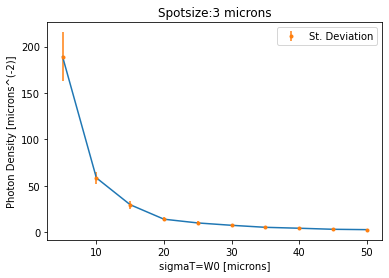

In [11]:
plt.plot(sigma,Pd_Mean[:,0])
plt.errorbar(sigma,Pd_Mean[:,0],Pd_STD[:,0], linestyle='None', marker='.',label='St. Deviation')
plt.xlabel('sigmaT=W0 [microns]')
plt.ylabel('Photon Density [microns^(-2)]')
plt.title(f'Spotsize:{spotsize1} microns')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize1}_Finite.png',dpi=200)

In [1]:
plt.plot(sigma,Pd_Mean[:,1])
plt.errorbar(sigma,Pd_Mean[:,1],Pd_STD[:,1], linestyle='None', marker='.',label='St. Deviation')
plt.xlabel('sigmaT=W0 [microns]')
plt.ylabel('Photon Density [microns^(-2)]')
plt.title(f'Spotsize:{spotsize2} microns')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize2}_Finite.png',dpi=200)

NameError: name 'plt' is not defined

In [13]:
# import pandas as pd
# import numpy as np
# import os
# Data=np.zeros((n,3))
# Data[:,0]=sigma
# Data[:,1]=Pd[:,0]
# Data[:,2]=Pd[:,1]
# df=pd.DataFrame(Data)

# List=["Sigma","3 microns              ","10 microns"]
# df.to_csv(f'{path}\Photon_Density.txt',header=List , index=None, sep="\t", mode='w')



# print(df)

In [14]:
'''
Saving the Data
'''


import pandas as pd
import numpy as np
import os
Data=np.zeros((n,r+1))
Data[:,0]=sigma
Data[:,1:r+1]=Pd[:,0,0:r]
df=pd.DataFrame(Data)

List=["SigmaT+W0","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density "]
df.to_csv(f'{path}\Photon_Density_Spotsize{spotsize1}.txt',header=List , index=None, sep="\t", mode='w')



print(df)

     0           1           2           3           4           5   \
0   5.0  185.486999  174.968417  176.626796  218.677009  202.613933   
1  10.0   55.281153   61.111236   53.138929   60.977543   61.211179   
2  15.0   35.875289   29.407491   26.716535   23.399405   37.052099   
3  20.0   13.883271   13.095244   16.172117   12.729549   19.017328   
4  25.0   12.694946    8.939838   12.115432    9.954497    8.962420   
5  30.0    6.958198    7.188319    9.353115    7.507454    7.307803   
6  35.0    5.074402    5.287550    5.246212    4.310601    4.737572   
7  40.0    4.061509    4.803489    3.658743    4.362037    2.881595   
8  45.0    2.533409    2.932931    3.313908    2.965862    3.330067   
9  50.0    3.032927    2.639156    2.332968    2.374108    2.743308   

           6           7           8           9           10  
0  230.555287  158.164748  202.524539  139.900648  202.644835  
1   59.641558   51.256493   46.975580   70.473228   64.733884  
2   26.303908   26.525469 

In [15]:
import pandas as pd
import numpy as np
import os
Data=np.zeros((n,r+1))
Data[:,0]=sigma
Data[:,1:r+1]=Pd[:,1,0:r]
df=pd.DataFrame(Data)

List=["SigmaT+W0","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density "]
df.to_csv(f'{path}\Photon_Density_Spotsize{spotsize2}.txt',header=List , index=None, sep="\t", mode='w')



print(df)

     0           1           2           3           4           5   \
0   5.0  202.798495  189.902170  198.939935  202.133324  209.712947   
1  10.0   61.601307   60.372208   63.255595   57.081624   57.716956   
2  15.0   29.886043   27.321793   28.007198   27.385239   29.357703   
3  20.0   16.416410   14.982782   16.780700   15.451542   16.291793   
4  25.0   10.139356   10.165706   10.428630   10.126399   10.123059   
5  30.0    7.261688    6.860935    6.779855    7.065021    6.602946   
6  35.0    4.795727    4.766536    5.049740    5.294967    5.092636   
7  40.0    3.819834    3.867732    3.970517    3.995916    4.195080   
8  45.0    3.176098    2.945414    2.990961    3.143380    3.202069   
9  50.0    2.610899    2.605189    2.495574    2.580483    2.653346   

           6           7           8           9           10  
0  184.519422  215.107830  189.407717  199.868209  209.421186  
1   55.719346   56.139860   57.213669   63.334965   60.727309  
2   27.172074   27.852917 

In [16]:
'''
Reading the text files
The final array p does not contain the Header files

'''
print(pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize2}.txt',header=None , sep="\t"))

r=pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize2}.txt',header=0 , sep="\t")
p=pd.DataFrame.to_numpy(r)


           0                   1                   2                   3   \
0   SigmaT+W0     Photon Density      Photon Density      Photon Density    
1         5.0  202.79849450245405  189.90217030336333  198.93993501492076   
2        10.0  61.601306551643866   60.37220834315422   63.25559482100298   
3        15.0  29.886042648554636   27.32179258618493  28.007197724589542   
4        20.0  16.416409812484325   14.98278185804939  16.780700050718657   
5        25.0  10.139356172752363  10.165706179040443  10.428629829208687   
6        30.0   7.261687619325207   6.860935331614288   6.779854797309838   
7        35.0   4.795726991589368   4.766536338910314   5.049739644385852   
8        40.0  3.8198343635627565  3.8677324390200734  3.9705168265738444   
9        45.0   3.176097730647984   2.945414368601092  2.9909608265687253   
10       50.0   2.610899078578873   2.605189129917473  2.4955743823186785   

                    4                   5                   6   \
0      Ph

In [17]:
print(Pd_STD)


[[26.24007324  9.37205021]
 [ 6.54376551  2.7385295 ]
 [ 4.37892618  1.0562221 ]
 [ 2.33536589  0.67320594]
 [ 1.56418486  0.28513545]
 [ 0.75408407  0.19586645]
 [ 0.40407372  0.28260721]
 [ 0.82153045  0.15557028]
 [ 0.32926582  0.08642194]
 [ 0.2905488   0.07633252]]
